In [1]:
! pip install pycountry_convert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 46.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.0/229.0 kB 15.3 MB/s eta 0:00:00
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681833 sha256=d143f4a54b8e19c8cfd7117ccddb121ba18de8ae145790d12cb710892c20e44b
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pycountry_convert as pc
import folium
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import plotly.graph_objs as go
import json
import plotly.offline as py
import seaborn as sns
plt.style.use('fivethirtyeight')

In [4]:
# Global Data
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [5]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


## Problem 1: Calculate the number of total cases, total deaths, total recovered, and total active by time (day units).

In [6]:
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, :'8/4/21']
dates = confirmed.keys()

total_cases = []
total_deaths = []
mortality_rate = []
recovery_rate = []
total_recovered = []
total_active = []
adjusted_dates = list(np.array([i for i in range(len(dates))]).reshape(-1, 1)[:, 0])

recoveries

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,82586,82586,82586,82586,82586,82586,82586,82586,82586,82586
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,130152,130166,130174,130187,130205,130222,130243,130256,130291,130314
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,111322,112050,112900,113707,114531,115276,116009,116770,117557,118409
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,14077,14113,14113,14180,14210,14210,14210,14296,14348,14380
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,35686,35742,35964,36025,36708,37255,37397,38360,39389,39582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,311526,311560,311622,311714,311772,311832,311918,312149,312289,312320
270,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,4166,4168,4168,4171,4171,4185,4200,4212,4232,4251
272,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,182665,183534,183957,185210,186211,187236,188106,188950,189341,189658


In [9]:
confirmed['Total'] = confirmed.sum(axis = 1)
deaths['Total'] = deaths.sum(axis = 1)
recoveries['Total'] = recoveries.sum(axis = 1)

total_cases = list(confirmed['Total'])
total_deaths = list(deaths['Total'])
total_recovered = list(recoveries['Total'])

confirmed.to_csv('confirmed_covid_cases.csv',index= False)


# total_cases = np.append(total_cases,np.sum(total_case))
# total_deaths = np.append(total_deaths,np.sum(total_cases))
# total_recovered = np.append(total_recovered,np.sum(total_recovered))
# total_active = total_case - total_deaths - total_recovered

confirmed

<ipython-input-9-918f66787dec>:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23,Total
0,0,0,0,0,0,0,0,0,0,0,...,209340,209358,209362,209369,209390,209406,209436,209451,209451,389965407
1,0,0,0,0,0,0,0,0,0,0,...,334408,334408,334427,334427,334427,334427,334427,334443,334457,556687962
2,0,0,0,0,0,0,0,0,0,0,...,271448,271463,271469,271469,271477,271477,271490,271494,271496,548224950
3,0,0,0,0,0,0,0,0,0,0,...,47875,47875,47875,47875,47875,47875,47875,47890,47890,73642575
4,0,0,0,0,0,0,0,0,0,0,...,105277,105277,105277,105277,105277,105277,105277,105288,105288,180075609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,1237631088
285,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,643386
286,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,23638305
287,0,0,0,0,0,0,0,0,0,0,...,343012,343079,343079,343079,343135,343135,343135,343135,343135,587861049


In [ ]:
np.sum(total_cases)

316910296319

In [ ]:
np.sum(total_deaths)

4419816964

In [ ]:
np.sum(total_cases) - np.sum(total_deaths) - np.sum(total_recovered)

577998046832

In [ ]:
np.sum(total_recovered)

46982911878

In [ ]:

total_cases.append(np.sum(total_cases))
total_deaths.append(np.sum(total_deaths))
total_recovered.append(np.sum(total_recovered))
total_active.append(np.sum(total_cases) - np.sum(total_deaths) - np.sum(total_recovered))



In [ ]:
total_deaths[-1]

4419816964

In [ ]:
total_active[-1]

577998046832

In [ ]:
print("Total confirmed cases: ", total_cases[-1])
print("Total death cases: ", total_deaths[-1])
print("Total recoveries cases: ", total_recovered[-1])
print("Total active cases: ", total_active[-1])

Total confirmed cases:  316910296319
Total death cases:  4419816964
Total recoveries cases:  23491455939
Total active cases:  577998046832


In [ ]:
len(total_recovered)

275

## Problem 2: Visualize the number and the log(10) of total cases, total deaths, total recovered, and total active by time (day units) in 2 graph (one for the number and the other for the log(10)) using line chart.

In [ ]:
total_cases_df = pd.DataFrame()
total_deaths_df = pd.DataFrame()
total_recoveries_df = pd.DataFrame()
total_active_df = pd.DataFrame()


total_cases_df['Total'] = (confirmed['Total'])
total_deaths_df['Total'] = (deaths['Total'])
total_recoveries_df['Total'] = (recoveries['Total'])
add = np.zeros(15)


add_df = pd.DataFrame(add)
total_recoveries_df = total_recoveries_df.append(add_df,ignore_index= True)
total_active_df['Total'] = (confirmed['Total'] - deaths['Total'] - recoveries['Total'])
total_active_df['Total'] = total_active_df['Total'].replace(np.nan,0)



<ipython-input-43-4308c3ca94c7>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
total_recoveries_df.drop([0],axis =1 ,inplace = True)

In [ ]:
total_recoveries_df = total_recoveries_df.replace(np.nan,0)

In [ ]:
total_active_df

,Total
0,106277154.0
1,160424622.0
2,152170142.0
3,21334686.0
4,52897569.0
...,...
284,0.0
285,0.0
286,0.0
287,0.0


In [ ]:
total_cases_df['log10'] = np.log10(total_cases_df['Total'])
total_deaths_df['log10'] = np.log10(total_deaths_df['Total'])
total_recoveries_df['log10'] = np.log10(total_recoveries_df['Total'])
total_active_df['log10'] = np.log10(total_active_df['Total'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log10

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log10



In [ ]:
total_cases_df['Total']

0      129988469
1      185562654
2      182741650
3       24547525
4       60025203
         ...    
284    412543696
285       214462
286      7879435
287    195953683
288    140385286
Name: Total, Length: 289, dtype: int64

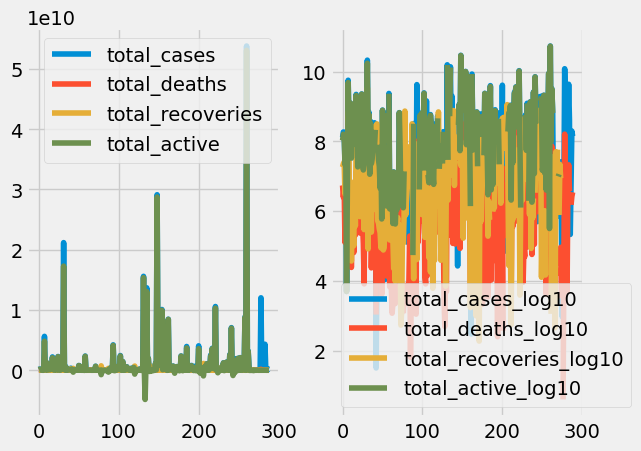

In [ ]:
x = [i for i in range(289)]

y1 = total_cases_df['Total']
y2 = total_deaths_df['Total']
y3 = total_recoveries_df['Total']
y4 = total_active_df['Total']

plt.subplot(1,2,1)

plt.plot(x,y1, label = 'total_cases')
plt.plot(x,y2, label = 'total_deaths')
plt.plot(x,y3, label = 'total_recoveries')
plt.plot(x,y4, label ='total_active')
plt.legend()


y5 = total_cases_df['log10']
y6 = total_deaths_df['log10']
y7 = total_recoveries_df['log10']
y8 = total_active_df['log10']
x2 = [i for i in range(289)]

plt.subplot(1,2,2)

plt.plot(x2,y5,label = 'total_cases_log10')
plt.plot(x2,y6,label = 'total_deaths_log10')
plt.plot(x2,y7,label = 'total_recoveries_log10')
plt.plot(x2,y8,label = 'total_active_log10')

plt.legend()

## Problem 3: Visualize the number of total cases, total deaths, total recovered, and total active by time (day units) in 4 separated graphs using line chart

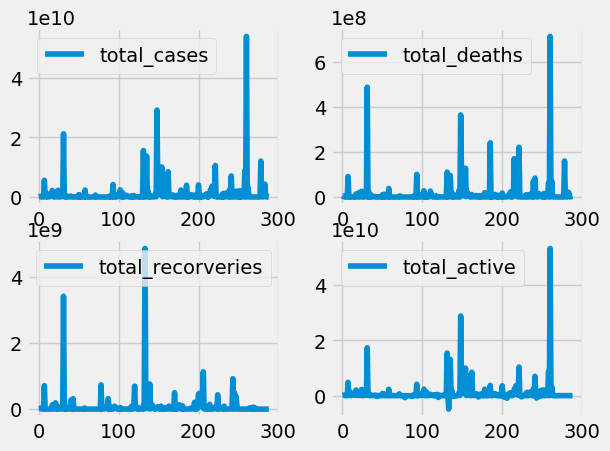

In [ ]:
x = [i for i in range(289)]

y1 = total_cases_df['Total']
y2 = total_deaths_df['Total']
y3 = total_recoveries_df['Total']
y4 = total_active_df['Total']

plt.subplot(2,2,1)
plt.plot(x,y1,label = 'total_cases')
plt.legend()

plt.subplot(2,2,2)
plt.plot(x,y2,label = 'total_deaths')
plt.legend()

plt.subplot(2,2,3)
plt.plot(x,y3,label = 'total_recorveries')
plt.legend()

plt.subplot(2,2,4)
plt.plot(x,y4,label = 'total_active')
plt.legend()